## Imports

In [1]:
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

import pyro
from pyro.infer import NUTS, MCMC, HMC
from pyro.infer import Predictive
from pyro.infer.autoguide import init_to_value

import numpy as np

import matplotlib.pyplot as plt

from src.models.TurbulenceNetwork import TurbulenceNetworkBayesian
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

%matplotlib inline

## MCMC Utils

In [2]:
def mean_eff_samples(diagnostics):
    total_eff_samples = 0
    total_params = 0
    for key in diagnostics.keys():
        if 'n_eff' not in diagnostics[key].keys():
            continue
        eff_samples = diagnostics[key]['n_eff'].sum().item()
        total_eff_samples += eff_samples
        total_params += diagnostics[key]['n_eff'].nelement()
    
    return total_eff_samples / total_params


## Creating Data

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:88: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


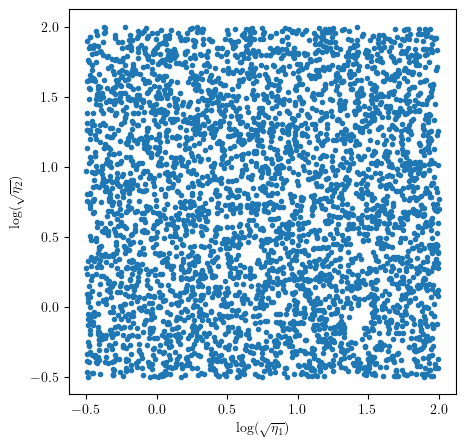

In [3]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 4_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

## Training Parameters

In [4]:
model_params = {
    "input_dim": 2,
    "output_dim": 3,
    "h_nodes": 5,
    "num_layers": 2,
    "data_size": etas_train.shape[0],
    "layer_prior": torch.tensor([0., 10.], device=device),
    "device": device,
    "output_prior": torch.tensor([0.1, 0.1, 0.1], device=device, dtype=torch.float32),
    "activation": nn.ReLU
}

tree_depth = 12

sampler_params = {
    "warmup_steps": 1000,
    "num_samples": 5000,
    "num_chains": 1
}

#gold_step_size = 55e-5
#gold_trajectory_length = 1.6501

step_size = 35e-5
trajectory_length = 1.901
num_steps = int(np.ceil(trajectory_length // step_size))
print("Number of Steps: ", num_steps)

Number of Steps:  5431


## Defining Data Sets and Scaling

In [5]:
x_scaler = CustomScalerX().fit(etas_train)
y_scaler = CustomScalerY().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_scaled_test = x_scaler.transform(etas_test)
y_scaled_test = y_scaler.transform(gs_test)

x_train = torch.tensor(x_scaled_train, dtype=torch.float32)
y_train = torch.tensor(y_scaled_train, dtype=torch.float32)

x_test = torch.tensor(x_scaled_test, dtype=torch.float32)
y_test = torch.tensor(y_scaled_test, dtype=torch.float32)

x_train = x_train.to(device)
y_train = y_train.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

## Training

In [6]:
model = TurbulenceNetworkBayesian(**model_params)

intialize_path = "Model_Checkpoints/NUTS_Test/NUTS_Initialize1.pt"

net_dict = torch.load(intialize_path, map_location=device)
#sigma_array = torch.tensor([5.0, 5.0, 5.0], device=device)

new_dict = {}
for k,v in net_dict.items():
    if '3' in k:
        new_dict[k.replace('3', '2')] = v
    elif '6' in k:
        new_dict[k.replace('6', '4')] = v
    else:
        new_dict[k] = v

#new_dict['sigma'] = sigma_array
new_dict = OrderedDict(new_dict)

print(new_dict.keys())

intitialization = init_to_value(values=new_dict)

display(model)

#nuts_kernel = NUTS(model, max_tree_depth=tree_depth, target_accept_prob=0.8, jit_compile=True)#, init_strategy=intitialization)
hmc_kernel = HMC(model, step_size=step_size, num_steps=num_steps, adapt_step_size=False, jit_compile=True, full_mass=True, init_strategy=intitialization, ignore_jit_warnings=True)
mcmc = MCMC(hmc_kernel, mp_context="spawn", **sampler_params)

mcmc.run(x_train, y_train)
mcmc.summary()

odict_keys(['layers.0.weight', 'layers.0.bias', 'layers.2.weight', 'layers.2.bias'])


TurbulenceNetworkBayesian(
  (layers): PyroModuleList(
    (0): PyroLinear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): PyroLinear(in_features=5, out_features=3, bias=True)
  )
)

Sample: 100%|██████████| 6000/6000 [8:47:35,  5.28s/it, step size=3.50e-04, acc. prob=0.753]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
    layers.0.bias[0]    -14.48      6.29    -14.00    -24.74     -4.55   2066.46      1.00
    layers.0.bias[1]     -1.95      2.62     -0.84     -5.52     -0.04    339.77      1.00
    layers.0.bias[2]     -0.24      0.16     -0.19     -0.49     -0.04    583.95      1.00
    layers.0.bias[3]      3.52      2.17      3.11      0.42      6.81     75.17      1.01
    layers.0.bias[4]     -0.69      0.66     -0.43     -1.70     -0.05     45.53      1.03
layers.0.weight[0,0]     -0.07      3.42     -0.04     -5.69      5.71   2150.71      1.00
layers.0.weight[0,1]      0.12      3.35      0.03     -5.13      5.95   2184.38      1.00
layers.0.weight[1,0]     -1.13      1.54     -0.48     -3.22     -0.03    340.07      1.00
layers.0.weight[1,1]     -0.82      1.12     -0.35     -2.35     -0.02    345.09      1.00
layers.0.weight[2,0]     -1.92      1.29     -1.55     -3.91     -0.35    573.46      1.0

## Saving MCMC Run

In [7]:
save_name = f"MCMC_model_{sampler_params['num_samples']}_{sampler_params['warmup_steps']}_{tree_depth}_{sampler_params['num_chains']}_{num_steps}"
save_MCMC_model(mcmc, "./Model_Checkpoints/NUTS_Test", save_name)


## Loading MCMC Run

608.1158225319602

                          mean       std    median      5.0%     95.0%     n_eff     r_hat
    layers.0.bias[0]    -14.48      6.29    -14.00    -24.74     -4.55   2066.46      1.00
    layers.0.bias[1]     -1.95      2.62     -0.84     -5.52     -0.04    339.77      1.00
    layers.0.bias[2]     -0.24      0.16     -0.19     -0.49     -0.04    583.95      1.00
    layers.0.bias[3]      3.52      2.17      3.11      0.42      6.81     75.17      1.01
    layers.0.bias[4]     -0.69      0.66     -0.43     -1.70     -0.05     45.53      1.03
layers.0.weight[0,0]     -0.07      3.42     -0.04     -5.69      5.71   2150.71      1.00
layers.0.weight[0,1]      0.12      3.35      0.03     -5.13      5.95   2184.38      1.00
layers.0.weight[1,0]     -1.13      1.54     -0.48     -3.22     -0.03    340.07      1.00
layers.0.weight[1,1]     -0.82      1.12     -0.35     -2.35     -0.02    345.09      1.00
layers.0.weight[2,0]     -1.92      1.29     -1.55     -3.91     -0.35 

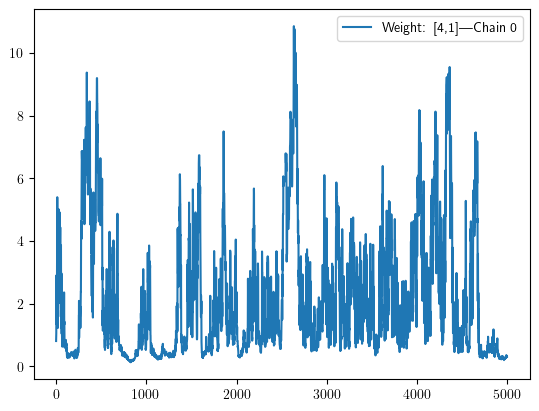

In [8]:
save_name = f"MCMC_model_{sampler_params['num_samples']}_{sampler_params['warmup_steps']}_{tree_depth}_{sampler_params['num_chains']}_{num_steps}"


model_test = TurbulenceNetworkBayesian(**model_params)
nuts_kernel_test = NUTS(model_test, max_tree_depth=tree_depth)

mcmc_test = load_MCMC_model("./Model_Checkpoints/NUTS_Test", save_name, nuts_kernel_test, sampler_params)

diag = mcmc_test.diagnostics()

print(mean_eff_samples(diag))

print(mcmc_test.summary())

samples = mcmc_test.get_samples(group_by_chain=True)

params = samples['layers.0.weight']

ind1 = 4
ind2 = 1
for i in range(1):
    plt.plot(params[i, :, ind1, ind2].cpu().numpy(), label=f"Weight: [{ind1},{ind2}]---Chain {i}")

plt.legend()
plt.show()


## Plotting Samples

tensor(0.0110, dtype=torch.float64)


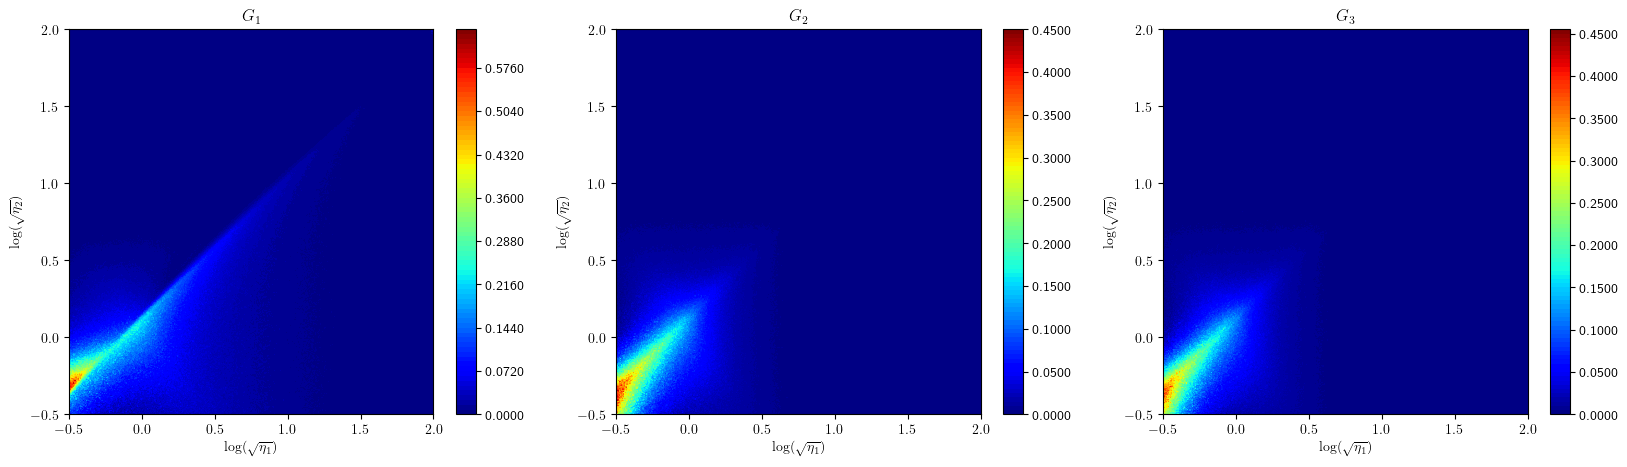

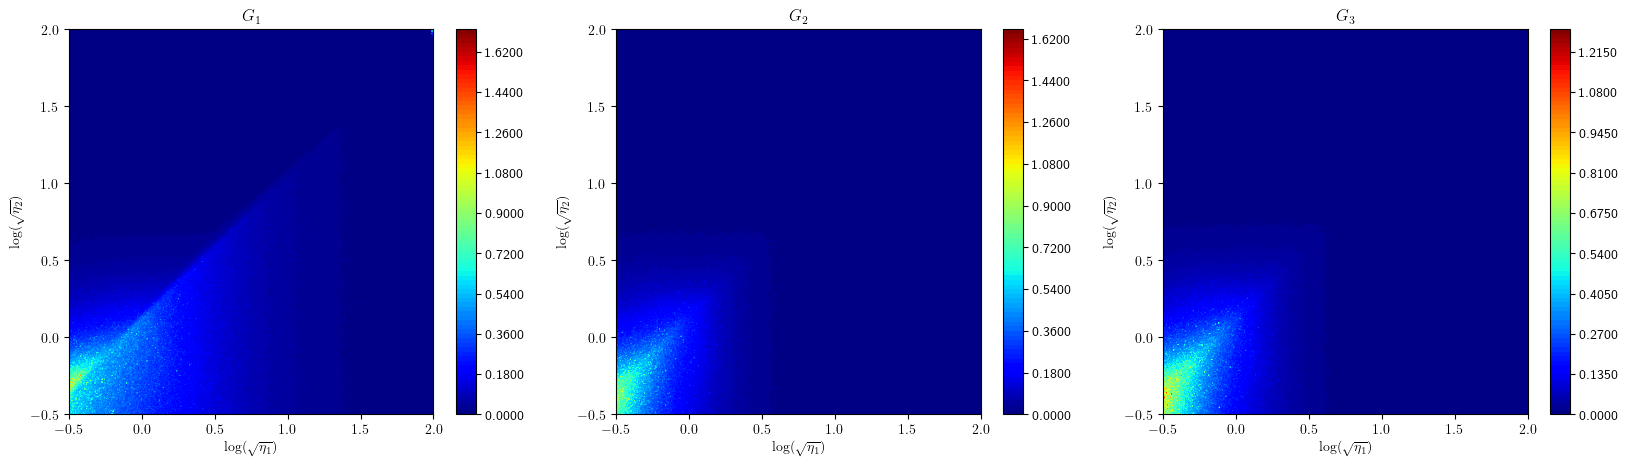

In [9]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

model_test.data_size = etas.shape[0]
etas = x_scaler.transform(etas)

predictive = Predictive(model_test, posterior_samples=mcmc_test.get_samples(400), return_sites=("obs",))

pred = predictive(torch.tensor(etas, dtype=torch.float32).to(device))['obs']

for i in range(pred.shape[0]):
    pred[i] = torch.tensor(y_scaler.inverse_transform(pred[i].cpu().detach().numpy())).to(device)

pred_mean = torch.mean(pred, axis=0).detach().cpu().numpy()
pred_std = torch.std(pred, axis=0).detach().cpu().numpy()

del pred
del predictive
torch.cuda.empty_cache()

print(torch.mean(torch.abs(torch.tensor(target) - pred_mean)))

target = target.T.reshape(3, dim, dim)
pred_mean = pred_mean.T.reshape(3, dim, dim)
pred_std = pred_std.T.reshape(3, dim, dim)

plot_heat_map_3D(x_grid, y_grid, np.abs(pred_mean - target))

plot_heat_map_3D(x_grid, y_grid, pred_std)

## Plotting By Chain

tensor(0.0036, dtype=torch.float64)


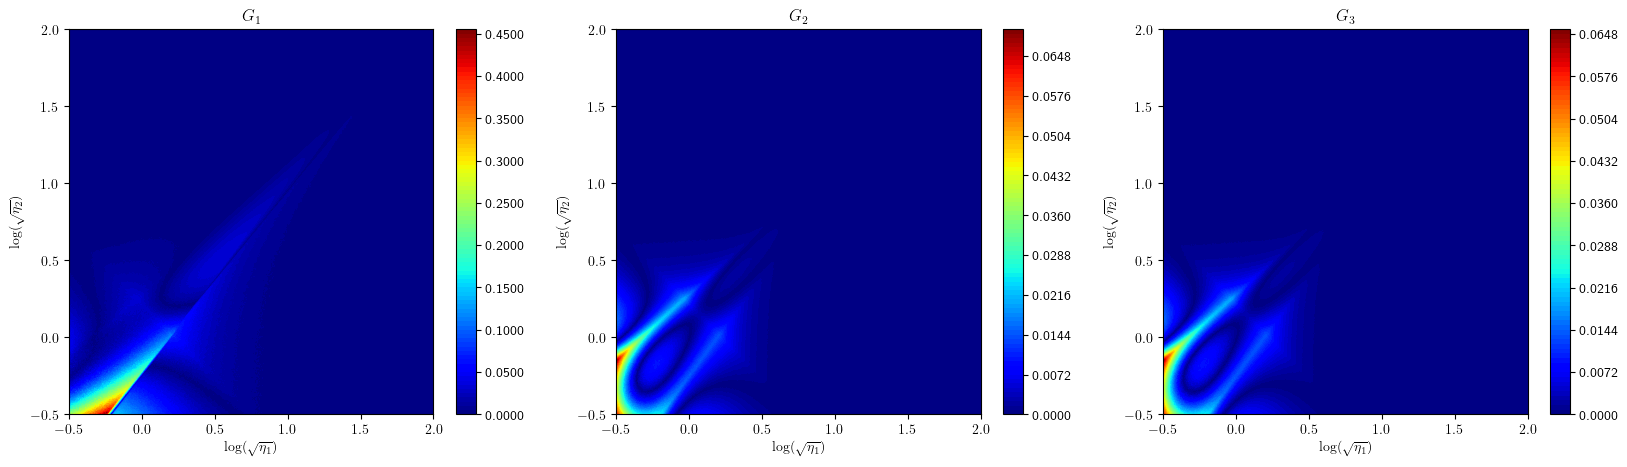

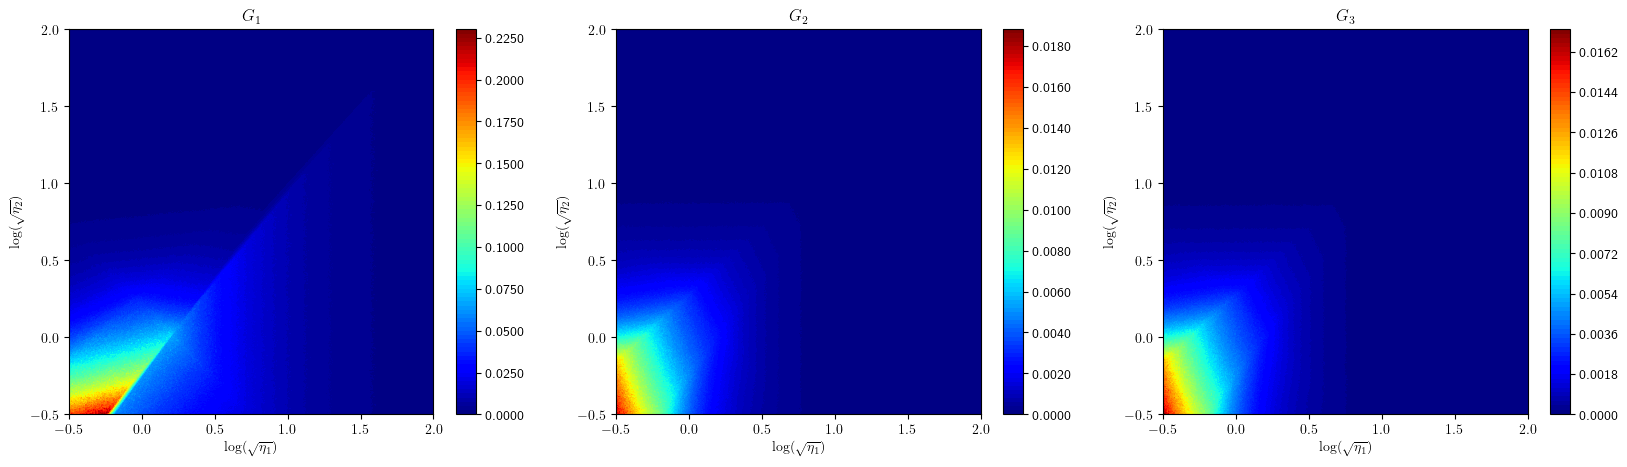

tensor(0.0041, dtype=torch.float64)


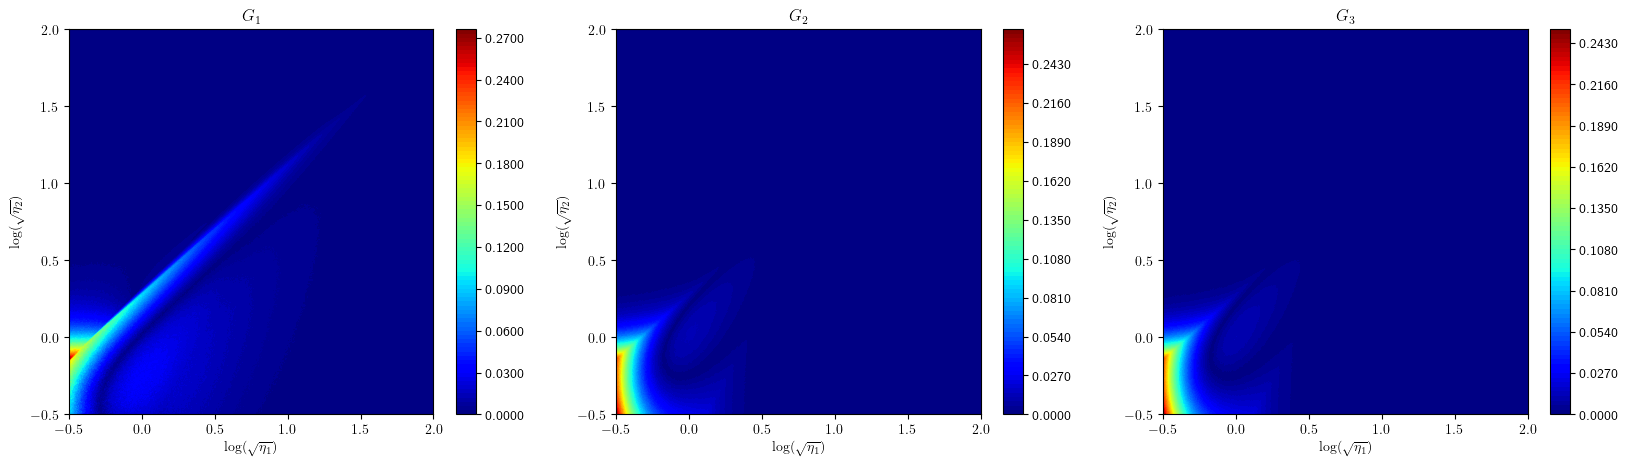

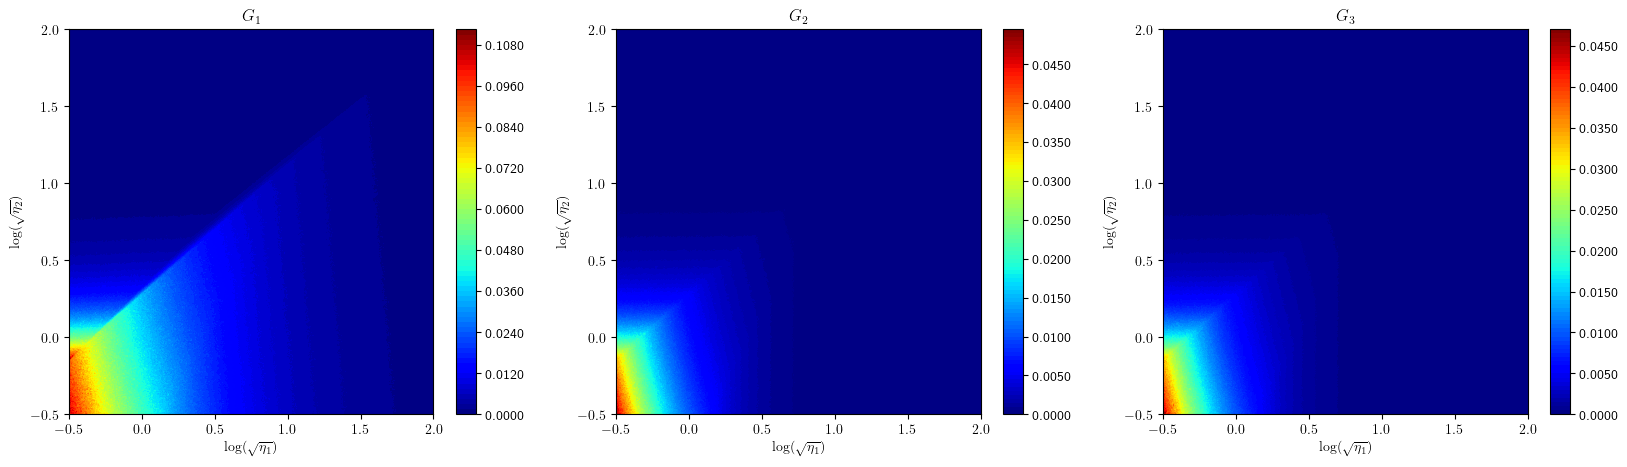

tensor(0.0024, dtype=torch.float64)


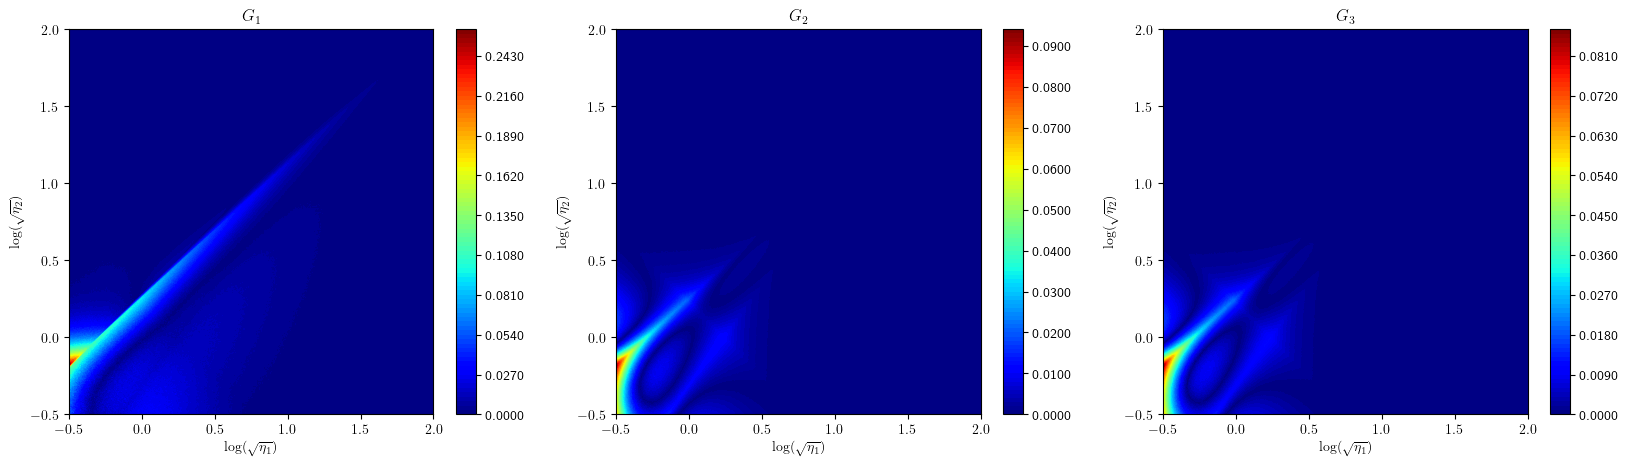

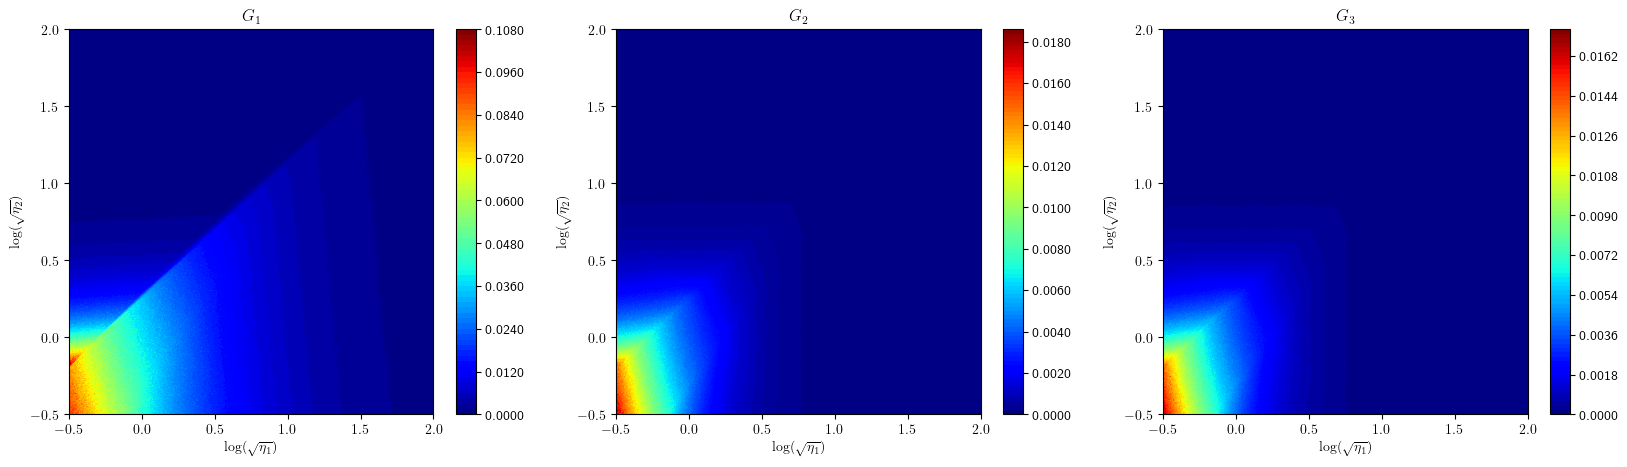

In [9]:
samples = mcmc_test.get_samples(group_by_chain=True)
num_samples = 400

for i in range(sampler_params['num_chains']):
    chain_sample_dict = OrderedDict()
    sample_indices = np.random.choice(samples['layers.2.weight'].shape[1], num_samples)
    for key in samples.keys():
        chain_sample_dict[key] = samples[key][i][sample_indices]

    predictive = Predictive(model_test, posterior_samples=chain_sample_dict, return_sites=("obs",))

    pred = predictive(torch.tensor(etas, dtype=torch.float32).to(device))['obs']

    for i in range(pred.shape[0]):
        pred[i] = torch.tensor(y_scaler.inverse_transform(pred[i].cpu().detach().numpy())).to(device)

    pred_mean = torch.mean(pred, axis=0).detach().cpu().numpy()
    pred_std = torch.std(pred, axis=0).detach().cpu().numpy()

    del pred
    del predictive
    torch.cuda.empty_cache()

    pred_mean = pred_mean.T.reshape(3, dim, dim)
    pred_std = pred_std.T.reshape(3, dim, dim)

    print(torch.mean(torch.abs(torch.tensor(target) - pred_mean)))

    
    plot_heat_map_3D(x_grid, y_grid, np.abs(pred_mean - target))

    plot_heat_map_3D(x_grid, y_grid, pred_std)
    

## Visualizing Samples

### Getting test outputs for each sample

In [80]:
predictive = Predictive(model, posterior_samples=mcmc_test.get_samples(1500), return_sites=("obs",))

test_preds = predictive(x_test)['obs'].cpu().detach()

for j in range(test_preds.shape[0]):
    test_preds[j] = torch.tensor(y_scaler.inverse_transform(test_preds[j].numpy()))
test_preds = test_preds.reshape(test_preds.shape[0], -1)

y_trans = y_scaler.inverse_transform(y_test.cpu().numpy()).flatten().reshape(1, -1)

test_outputs = np.concatenate([test_preds, y_trans], axis=0)

print(test_outputs.shape)

Warmup:  34%|███▎      | 134/400 [27:25:37, 736.85s/it, step size=2.24e-04, acc. prob=0.691]


(1501, 1800)


### Visualizing Sample Outputs

Calculating PHATE...
  Running PHATE on 1501 observations and 1800 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.58 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.18 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.79 seconds.
  Calculating optimal t...
    Automatically selected t = 5
  Calculated optimal t in 0.81 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.16 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.11 seconds.
Calculated PHATE in 3.88 seconds.


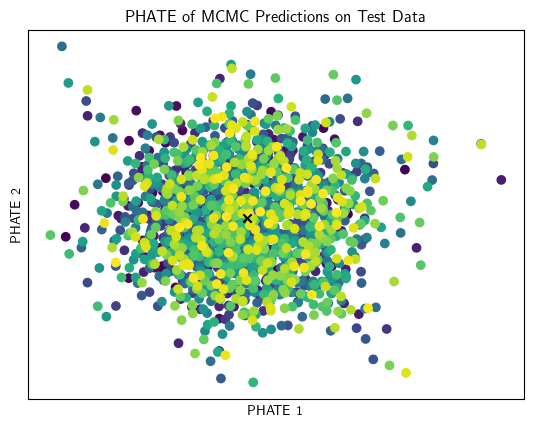

In [81]:
from phate import PHATE

phate_op = PHATE(n_components=2)

phate_outputs = phate_op.fit_transform(test_outputs)

plt.scatter(phate_outputs[0:-1, 0], phate_outputs[0:-1, 1], c=range(test_outputs.shape[0] - 1))

plt.scatter(phate_outputs[-1, 0], phate_outputs[-1, 1], c='black', marker='x')

plt.title("PHATE of MCMC Predictions on Test Data")

plt.xticks([])
plt.yticks([])

plt.xlabel("PHATE 1")
plt.ylabel("PHATE 2")

plt.show()